# Practica 3

José Delgado, Javier Ortí, Joan Benlloch

1. Estructura de los datos\
*Carpeta images*: Contiene las imágenes originales de los problemas gastrointestinales, que son las entradas (X) del modelo. Estas imágenes tienen características que el modelo necesita aprender para identificar áreas relevantes.\
*Carpeta masks*: Contiene las máscaras de segmentación correspondientes, que son las salidas deseadas (y). Cada máscara tiene el mismo tamaño que su imagen correspondiente y está compuesta por valores binarios (0 y 1):\
0: Representa los píxeles de fondo (no relacionados con el área de interés).\
1: Representa los píxeles que pertenecen a la región de interés (por ejemplo, pólipos o anomalías).\
El modelo se entrena para generar máscaras similares a las de la carpeta masks al procesar imágenes de la carpeta images.

### 1. Preparar el Dataset

transformamos las imágenes y las máscaras en un formato que el modelo pueda procesar:

Carga de imágenes y máscaras: Se leen los archivos .jpg de ambas carpetas, asegurando que cada máscara esté correctamente alineada con su imagen correspondiente.\
Redimensionamiento: Todas las imágenes y máscaras se redimensionan a un tamaño fijo (256x256 en este caso) para que puedan pasar por el modelo. Esto es necesario porque los modelos de deep learning requieren tamaños uniformes.\
Normalización:\
Las imágenes se normalizan dividiendo los valores de los píxeles por 255 (para que estén en el rango [0, 1]).\
Las máscaras permanecen en valores binarios (0 o 1) para representar correctamente las áreas de segmentación.

In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split

IMG_HEIGHT, IMG_WIDTH = 256, 256

def load_data(image_dir, mask_dir):
    images, masks = [], []
    for img_name in os.listdir(image_dir):
        img_path = os.path.join(image_dir, img_name)
        mask_path = os.path.join(mask_dir, img_name)
        image = img_to_array(load_img(img_path, target_size=(IMG_HEIGHT, IMG_WIDTH))) / 255.0
        mask = img_to_array(load_img(mask_path, target_size=(IMG_HEIGHT, IMG_WIDTH), color_mode="grayscale")) / 255.0
        images.append(image)
        masks.append(mask)
    return np.array(images), np.array(masks)

image_dir = 'images'
mask_dir = 'masks'
images, masks = load_data(image_dir, mask_dir)

X_train, X_val, y_train, y_val = train_test_split(images, masks, test_size=0.2, random_state=42)


In [2]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((800, 256, 256, 3),
 (800, 256, 256, 1),
 (200, 256, 256, 3),
 (200, 256, 256, 1))

### 2. Transfer Learning de ResNeXt50 para hacer un Autoencoder (2017)

3. Entrenamiento del modelo\
El proceso de entrenamiento consiste en mostrar al modelo imágenes de entrada (X) y sus máscaras correspondientes (y), de manera que pueda aprender la relación entre ambas.

Entrada (X): Imagen original (por ejemplo, una imagen de una colonoscopia).\
Salida esperada (y): Máscara correspondiente, donde los píxeles que representan pólipos están marcados con 1.\
En cada iteración:

La imagen pasa por la red convolucional (DeepLab o el modelo definido) que genera una máscara predicha (y_pred) de dimensiones (256x256x1).\
El modelo compara la máscara predicha (y_pred) con la máscara real (y) utilizando la función de pérdida (en este caso, binary cross-entropy).\
Los gradientes calculados por la pérdida ajustan los pesos del modelo para mejorar futuras predicciones.

4. Cómo aprende el modelo\
Durante el entrenamiento:

El modelo extrae características de las imágenes usando capas convolucionales.\
Por ejemplo, identifica patrones relacionados con bordes, texturas y colores que son típicos de las áreas de interés (como los pólipos).\
Las capas de upsampling (deconvoluciones) reconstruyen la máscara a partir de estas características aprendidas, pixel a pixel.\
El modelo ajusta sus pesos para minimizar la diferencia entre la máscara generada (y_pred) y la máscara real (y).

In [1]:
!pip install git+https://github.com/qubvel/classification_models.git

Defaulting to user installation because normal site-packages is not writeable

  Running command git clone --filter=blob:none --quiet https://github.com/qubvel/classification_models.git 'C:\Users\joanb\AppData\Local\Temp\pip-req-build-g2s30072'
  Running command git submodule update --init --recursive -q

[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: C:\Program Files\Python310\python.exe -m pip install --upgrade pip



  Cloning https://github.com/qubvel/classification_models.git to c:\users\joanb\appdata\local\temp\pip-req-build-g2s30072
  Resolved https://github.com/qubvel/classification_models.git to commit a0f006e05485a34ccf871c421279864b0ccd220b
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     ---------------------------------------- 0.0/50.7 kB ? eta -:--:--
     ---------------------------------------- 50.7/50.7 kB ? eta 0:00:00
  Created wheel for image-classifiers: filename=image_classifiers-1.0.0-py3-none-any.whl size=20206 sha256=4e415d6ea801c6743576f5d275aec23c91e082eb6ae019b354ff34fa7d0b5ee7
  Stored in directory: C:\Users\joanb\AppData\Local\Temp\pip-ephem-wheel-cache-243j0oxn\wheels\f5\13\cb\b1dbd79043c5a389742e422859b0b663adcd7b5c220928c339
Successfully built image-classifiers


In [3]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import UpSampling2D, Conv2D
from classification_models.tfkeras import Classifiers

In [4]:


def build_deeplab_model_resnext(input_size=(256, 256, 3), model_name='resnext50'):
    # Selección del modelo (ResNeXt50 o ResNeXt101)
    ResNeXt, preprocess_input = Classifiers.get(model_name)
    
    # Cargar el modelo base
    base_model = ResNeXt(include_top=False, input_shape=input_size, weights="imagenet")
    base_model.trainable = False  # Congelar los pesos preentrenados

    # Extraer la última capa del modelo base
    x = base_model.output  # Salida típica: (None, 8, 8, 2048)

    # Upsampling para restaurar el tamaño original
    x = UpSampling2D(size=(2, 2), interpolation='bilinear')(x)  # De 8x8 a 16x16
    x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)

    x = UpSampling2D(size=(2, 2), interpolation='bilinear')(x)  # De 16x16 a 32x32
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)

    x = UpSampling2D(size=(2, 2), interpolation='bilinear')(x)  # De 32x32 a 64x64
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)

    x = UpSampling2D(size=(4, 4), interpolation='bilinear')(x)  # De 64x64 a 256x256
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)

    # Salida final con un canal (máscara binaria)
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(x)
    
    # Crear el modelo final
    model = Model(inputs=base_model.input, outputs=outputs)
    
    return model

# Construir el modelo con ResNeXt50
model = build_deeplab_model_resnext(model_name='resnext50')
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 data (InputLayer)              [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 bn_data (BatchNormalization)   (None, 256, 256, 3)  9           ['data[0][0]']                   
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 262, 262, 3)  0          ['bn_data[0][0]']                
                                                                                                  
 conv0 (Conv2D)                 (None, 128, 128, 64  9408        ['zero_padding2d[0][0]']   

In [10]:
output_shape = model.output_shape
print(f"Output shape of the model: {output_shape}")  # Debería ser (None, 256, 256, 1)


Output shape of the model: (None, 256, 256, 1)


### 3. Entrenar el Modelo

He parado el entrenamiento en la epoch 36

In [5]:
batch_size = 16
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=35,
    batch_size=batch_size
)

Epoch 1/35
50/50 [==============================] - 35s 330ms/step - loss: 0.3962 - accuracy: 0.8387 - val_loss: 0.3936 - val_accuracy: 0.8357
Epoch 2/35
50/50 [==============================] - 12s 238ms/step - loss: 0.3606 - accuracy: 0.8433 - val_loss: 0.3634 - val_accuracy: 0.8357
Epoch 3/35
50/50 [==============================] - 12s 238ms/step - loss: 0.3544 - accuracy: 0.8437 - val_loss: 0.3564 - val_accuracy: 0.8395
Epoch 4/35
50/50 [==============================] - 12s 248ms/step - loss: 0.3522 - accuracy: 0.8434 - val_loss: 0.3534 - val_accuracy: 0.8377
Epoch 5/35
50/50 [==============================] - 13s 252ms/step - loss: 0.3540 - accuracy: 0.8442 - val_loss: 0.3556 - val_accuracy: 0.8364
Epoch 6/35
50/50 [==============================] - 13s 251ms/step - loss: 0.3475 - accuracy: 0.8451 - val_loss: 0.3526 - val_accuracy: 0.8378
Epoch 7/35
50/50 [==============================] - 13s 255ms/step - loss: 0.3478 - accuracy: 0.8463 - val_loss: 0.3498 - val_accuracy: 0.8411

### 4. Fine-tuning

In [11]:
model_name='resnext50'
ResNeXt, preprocess_input = Classifiers.get(model_name)

In [12]:
input_size=(IMG_HEIGHT, IMG_WIDTH, 3)
# Descongelar las últimas capas del modelo base
base_model = ResNeXt(include_top=False, input_shape=input_size, weights="imagenet")
base_model.trainable = True
fine_tune_at = 100  # Número de capas a descongelar

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss='binary_crossentropy',
              metrics=['accuracy'])




In [13]:
#hago una copia del modelo para hacer el fuine tuning
model_fine_tuned = model

In [23]:
history_fine = model_fine_tuned.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=5,
    batch_size=batch_size
)

Epoch 1/5


ResourceExhaustedError: Graph execution error:

Detected at node 'gradient_tape/model_1/conv2d_515/Conv2D/Conv2DBackpropInput' defined at (most recent call last):
    File "c:\Users\joanb\anaconda3\envs\tf_env\lib\runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "c:\Users\joanb\anaconda3\envs\tf_env\lib\runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "C:\Users\joanb\AppData\Roaming\Python\Python310\site-packages\ipykernel_launcher.py", line 18, in <module>
      app.launch_new_instance()
    File "C:\Users\joanb\AppData\Roaming\Python\Python310\site-packages\traitlets\config\application.py", line 1075, in launch_instance
      app.start()
    File "C:\Users\joanb\AppData\Roaming\Python\Python310\site-packages\ipykernel\kernelapp.py", line 739, in start
      self.io_loop.start()
    File "C:\Users\joanb\AppData\Roaming\Python\Python310\site-packages\tornado\platform\asyncio.py", line 205, in start
      self.asyncio_loop.run_forever()
    File "c:\Users\joanb\anaconda3\envs\tf_env\lib\asyncio\base_events.py", line 603, in run_forever
      self._run_once()
    File "c:\Users\joanb\anaconda3\envs\tf_env\lib\asyncio\base_events.py", line 1909, in _run_once
      handle._run()
    File "c:\Users\joanb\anaconda3\envs\tf_env\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\joanb\AppData\Roaming\Python\Python310\site-packages\ipykernel\kernelbase.py", line 545, in dispatch_queue
      await self.process_one()
    File "C:\Users\joanb\AppData\Roaming\Python\Python310\site-packages\ipykernel\kernelbase.py", line 534, in process_one
      await dispatch(*args)
    File "C:\Users\joanb\AppData\Roaming\Python\Python310\site-packages\ipykernel\kernelbase.py", line 437, in dispatch_shell
      await result
    File "C:\Users\joanb\AppData\Roaming\Python\Python310\site-packages\ipykernel\ipkernel.py", line 362, in execute_request
      await super().execute_request(stream, ident, parent)
    File "C:\Users\joanb\AppData\Roaming\Python\Python310\site-packages\ipykernel\kernelbase.py", line 778, in execute_request
      reply_content = await reply_content
    File "C:\Users\joanb\AppData\Roaming\Python\Python310\site-packages\ipykernel\ipkernel.py", line 449, in do_execute
      res = shell.run_cell(
    File "C:\Users\joanb\AppData\Roaming\Python\Python310\site-packages\ipykernel\zmqshell.py", line 549, in run_cell
      return super().run_cell(*args, **kwargs)
    File "C:\Users\joanb\AppData\Roaming\Python\Python310\site-packages\IPython\core\interactiveshell.py", line 3075, in run_cell
      result = self._run_cell(
    File "C:\Users\joanb\AppData\Roaming\Python\Python310\site-packages\IPython\core\interactiveshell.py", line 3130, in _run_cell
      result = runner(coro)
    File "C:\Users\joanb\AppData\Roaming\Python\Python310\site-packages\IPython\core\async_helpers.py", line 128, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\joanb\AppData\Roaming\Python\Python310\site-packages\IPython\core\interactiveshell.py", line 3334, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\Users\joanb\AppData\Roaming\Python\Python310\site-packages\IPython\core\interactiveshell.py", line 3517, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "C:\Users\joanb\AppData\Roaming\Python\Python310\site-packages\IPython\core\interactiveshell.py", line 3577, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\joanb\AppData\Local\Temp\ipykernel_15424\2068993340.py", line 1, in <module>
      history_fine = model_fine_tuned.fit(
    File "C:\Users\joanb\AppData\Roaming\Python\Python310\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\joanb\AppData\Roaming\Python\Python310\site-packages\keras\engine\training.py", line 1564, in fit
      tmp_logs = self.train_function(iterator)
    File "C:\Users\joanb\AppData\Roaming\Python\Python310\site-packages\keras\engine\training.py", line 1160, in train_function
      return step_function(self, iterator)
    File "C:\Users\joanb\AppData\Roaming\Python\Python310\site-packages\keras\engine\training.py", line 1146, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\joanb\AppData\Roaming\Python\Python310\site-packages\keras\engine\training.py", line 1135, in run_step
      outputs = model.train_step(data)
    File "C:\Users\joanb\AppData\Roaming\Python\Python310\site-packages\keras\engine\training.py", line 997, in train_step
      self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "C:\Users\joanb\AppData\Roaming\Python\Python310\site-packages\keras\optimizers\optimizer_v2\optimizer_v2.py", line 576, in minimize
      grads_and_vars = self._compute_gradients(
    File "C:\Users\joanb\AppData\Roaming\Python\Python310\site-packages\keras\optimizers\optimizer_v2\optimizer_v2.py", line 634, in _compute_gradients
      grads_and_vars = self._get_gradients(
    File "C:\Users\joanb\AppData\Roaming\Python\Python310\site-packages\keras\optimizers\optimizer_v2\optimizer_v2.py", line 510, in _get_gradients
      grads = tape.gradient(loss, var_list, grad_loss)
Node: 'gradient_tape/model_1/conv2d_515/Conv2D/Conv2DBackpropInput'
OOM when allocating tensor with shape[16,256,256,128] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node gradient_tape/model_1/conv2d_515/Conv2D/Conv2DBackpropInput}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_135137]

### 5. Evaluar y Guardar el Modelo

In [6]:
loss, acc = model.evaluate(X_val, y_val, batch_size=8)
print(f"Validation Loss: {loss}, Validation Accuracy: {acc}")

model.save('deeplabv3_segmentation.h5')


25/25 [==============================] - 2s 91ms/step - loss: 0.3342 - accuracy: 0.8413
Validation Loss: 0.334174245595932, Validation Accuracy: 0.8413347005844116


In [15]:
# Evaluación del modelo fine-tuned
loss, acc = model_fine_tuned.evaluate(X_val, y_val, batch_size=8)
print(f"Validation Loss: {loss}, Validation Accuracy: {acc}")

model_fine_tuned.save('deeplabv3_segmentation_finetuned.h5')


25/25 [==============================] - 2s 91ms/step - loss: 0.3297 - accuracy: 0.8455
Validation Loss: 0.32967203855514526, Validation Accuracy: 0.845488429069519


### Graficas de pérdida

In [2]:
#Hago graficas para la loss de modelo

import matplotlib.pyplot as plt

def plot_loss(history, title):
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='validation')
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()





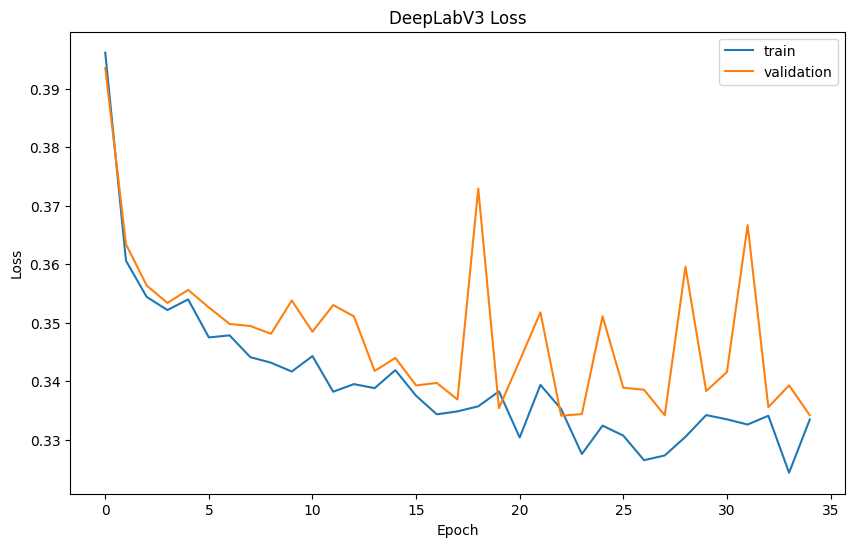

In [21]:
plot_loss(history, "DeepLabV3 Loss")

In [3]:
plot_loss(history_fine, "DeepLabV3 Fine-tuned Loss")


NameError: name 'history_fine' is not defined